In [1]:
import matplotlib.pyplot as plt
import optax
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import pickle
# from models.pennylane_models import serial, serial_2qubits, strongly_parallel, all_to_all_parallel, all_to_all_crz, all_to_all_rzz, strongly_crz, strongly_rzz, basic_mixed, one_to_all_mixed, all_to_one_mixed
from models.cnot_models import *
from models.controlled_rotations import *
from models.ising_coupling import *


def keygenerator(seed=42):
    key = jax.random.PRNGKey(seed)
    while True:
        key, subkey = jax.random.split(key)
        yield subkey

In [2]:
coeffs = [
    (1.29 + 1.13j),  # c_1
    (0.43 + 0.89j),  # c_2
    (1.97 + 1.03j),  # c_3
    (0.17 + 0.59j),  # c_4
    (1.71 + 1.41j),  # c_5
    (0.61 + 0.37j),  # c_6
    (1.19 + 1.67j),  # c_7
    (0.73 + 1.61j),  # c_8
    (0.23 + 0.47j),  # c_9
    (1.83 + 0.83j),  # c_10
]

c0 = 0.0
scaling = 1

def target_function(x):
    res = c0
    for idx, c in enumerate(coeffs):
        exponent = scaling * (idx + 1) * x * 1j
        conj_c = jnp.conjugate(c)
        res += c * jnp.exp(exponent) + conj_c * jnp.exp(-exponent)
    return jnp.real(res)

def minmax_scaler(y):
    # Scale y to [0, 1]
    y_min = jnp.min(y)
    y_max = jnp.max(y)
    y_scaled = (y - y_min) / (y_max - y_min)
    return y_scaled

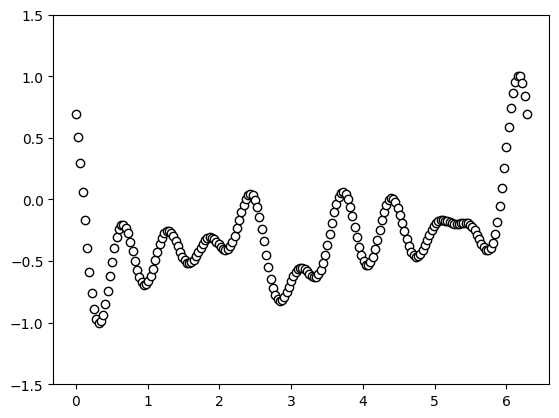

In [3]:
x_raw = jnp.linspace(-12, 12, 200)
x = minmax_scaler(x_raw) * 2 * jnp.pi
target_y = jax.vmap(target_function)(x)

target_y_scaled = minmax_scaler(target_y) * 2 - 1

# plt.plot(x, target_y, c="black")
plt.scatter(x, target_y_scaled, facecolor="white", edgecolor="black")
plt.ylim(-1.5, 1.5)
plt.show()

C:\Users\test\AppData\Local\Temp\ipykernel_7488\3889699004.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


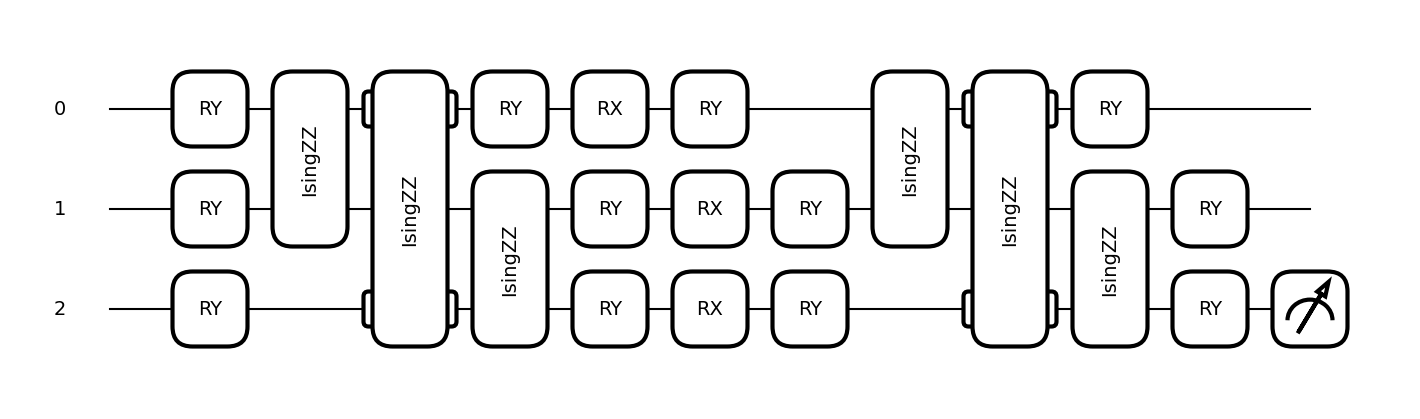

In [27]:
keys = keygenerator()
degree = len(coeffs)
num_exp_encodings = int(jnp.ceil(jnp.log(degree) / jnp.log(3)))

serial_models = ([serial(x, degree, 1, 1, next(keys))] +
                 [serial_2qubits(x, degree, l, 1, next(keys), next(keys)) for l in range(1, 6)] +
                 [serial_crz(x, degree, l, 1, next(keys), next(keys)) for l in range(1, 6)] +
                 [serial_cry(x, degree, l, 1, next(keys), next(keys)) for l in range(1, 6)] +
                 [serial_crx_ry(x, degree, l, 1, next(keys), next(keys)) for l in range(1, 6)] +
                 [serial_crx_rz(x, degree, l, 1, next(keys), next(keys)) for l in range(1, 6)] +
                 [serial_ry_crx_rz(x, degree, l, 1, next(keys)) for l in range(1, 6)])

basic_parallel_models = [basic_rot(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 12)]
strongly_parallel_models = [strongly_rot(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(2, 12)]
all_to_all_parallel_models = [all_to_all_parallel(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 12)]

strongly_controlled_models = ([strongly_crz(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 10)] +
                              [strongly_cry(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 10)] +
                              [strongly_crx_ry(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 10)] +
                              [strongly_crx_rz(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 10)] +
                              [strongly_ry_crx_rz(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys)) for l in range(1, 10)])
strongly_ising_models = ([strongly_rzz(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 10)] +
                         [strongly_ryy(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 10)] +
                         [strongly_rxx_ry(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 10)] +
                         [strongly_rxx_rz(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 10)] +
                         [strongly_ry_rxx_rz(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys)) for l in range(1, 10)])
all_to_all_controlled_models = ([all_to_all_crz(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 5)] +
                                [all_to_all_cry(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 5)] +
                                [all_to_all_crx_ry(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 5)] +
                                [all_to_all_crx_rz(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 5)] +
                                [all_to_all_ry_crx_rz(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys)) for l in range(1, 5)])
all_to_all_ising_models = ([all_to_all_rzz(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 8)] +
                           [all_to_all_ryy(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 8)] +
                           [all_to_all_rxx_ry(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 8)] +
                           [all_to_all_rxx_rz(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 8)] +
                           [all_to_all_ry_rxx_rz(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys)) for l in range(1, 8)])

# basic_mixed_models = [basic_mixed(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 8)]
# one_to_all_mixed_models = [one_to_all_mixed(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 8)]
# all_to_one_mixed_models = [all_to_one_mixed(x, n_qubits=degree, trainable_layers=l, scaling=1, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 8)]

exp_serial_models = ([serial(x, degree=num_exp_encodings, trainable_blocks=1, scaling=3, random_key=next(keys))] +
                     [serial_2qubits(x, num_exp_encodings, l, 3, next(keys), next(keys)) for l in range(1, 6)])
exp_basic_parallel_models = [basic_rot(x, n_qubits=num_exp_encodings, trainable_layers=l, scaling=3, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 8)]
exp_strongly_parallel_models = [strongly_rot(x, n_qubits=num_exp_encodings, trainable_layers=l, scaling=3, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 8)]
exp_all_to_all_parallel_models = [all_to_all_parallel(x, n_qubits=num_exp_encodings, trainable_layers=l, scaling=3, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 8)]

exp_strongly_crz_models = [strongly_crz(x, n_qubits=num_exp_encodings, trainable_layers=l, scaling=3, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 10)]
exp_strongly_rzz_models = [strongly_rzz(x, n_qubits=num_exp_encodings, trainable_layers=l, scaling=3, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 10)]
exp_all_to_all_crz_models = [all_to_all_crz(x, n_qubits=num_exp_encodings, trainable_layers=l, scaling=3, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 5)]
exp_all_to_all_rzz_models = [all_to_all_rzz(x, n_qubits=num_exp_encodings, trainable_layers=l, scaling=3, random_key1=next(keys), random_key2=next(keys)) for l in range(1, 8)]

exp_models = [exp_serial_models, exp_basic_parallel_models, exp_strongly_parallel_models, exp_all_to_all_parallel_models,
              exp_strongly_crz_models, exp_strongly_rzz_models,
              exp_all_to_all_crz_models, exp_all_to_all_rzz_models
              ]

varying_models = [serial_models, basic_parallel_models, strongly_parallel_models, all_to_all_parallel_models,
                  strongly_controlled_models, strongly_ising_models,
                  all_to_all_controlled_models, all_to_all_ising_models
                  ]

qm, weights, name = exp_all_to_all_rzz_models[0] # strongly_parallel2(x, 10, 9, 1, next(keys))
# print(qml.draw(qm, level="device")(weights, x))
fig, ax = qml.draw_mpl(qm, level="device")(weights, x)
fig.show()

In [ ]:
def square_loss(targets, predictions):
    return 0.5 * jnp.mean((targets - predictions) ** 2)

def cost(weights, model, x, y):
    predictions = jax.vmap(lambda x_: model(weights, x_))(x)
    # predictions = model(weights, x)
    return square_loss(y, predictions)

def r2_score(y_true, y_pred):
    ss_resid = jnp.sum((y_true - y_pred) ** 2)
    ss_total = jnp.sum((y_true - jnp.mean(y_true)) ** 2)
    return 1 - ss_resid / ss_total


class GradientLogger:
    def __init__(self):
        self.log = {
            "step": [],
            "loss": [],
            "grad_mean": [],
            "grad_std": [],
            "grad_min": [],
            "grad_max": [],
        }

    def get_gradients(self, weights, model, x, target_y):
        cost_fn = lambda w: cost(w, model, x, target_y)
        grads = jax.grad(cost_fn)(weights)

        # Flatten all gradient arrays into a single vector
        flat_grads = jnp.concatenate([jnp.ravel(g) for g in jax.tree_util.tree_leaves(grads)])

        return flat_grads

    def update(self, step, loss_val, flat_grads):
        self.log["step"].append(step)
        self.log["loss"].append(loss_val)
        self.log["grad_mean"].append(jnp.mean(flat_grads))
        self.log["grad_std"].append(jnp.std(flat_grads))
        self.log["grad_min"].append(jnp.min(flat_grads))
        self.log["grad_max"].append(jnp.max(flat_grads))

    def get_logs(self):
        return self.log

In [ ]:
predictions_r2scores_models = []
gradient_logger = []
costs = []

for models in varying_models:
    layer = 0
    plt.plot(x, target_y_scaled, c="black")
    plt.scatter(x, target_y_scaled, facecolor="white", edgecolor="black")

    for model in models:
        qm, weights, name = model
        qm = jax.jit(qm)
        opt = optax.adam(0.01)
        opt_state = opt.init(weights)
        layer += 1
        if models in (serial_models, strongly_parallel_models):
            d = weights.size
        else:
            d = weights['W'].size + weights['final'].size

        @jax.jit
        def update_step(weights, opt_state, x_batch, y_batch):
            loss_fn = lambda w: cost(w, qm, x_batch, y_batch)
            loss, grads = jax.value_and_grad(loss_fn)(weights)
            # loss, grads = jax.value_and_grad(cost)(qm, weights, x_batch, y_batch)
            updates, opt_state = opt.update(grads, opt_state)
            weights = optax.apply_updates(weights, updates)
            return weights, opt_state, loss

        max_steps = 5000
        batch_size = 25
        cst = [cost(weights, qm, x, target_y)]  # initial cost
        logger = GradientLogger()

        for step in range(max_steps):

            batch_index = jax.random.choice(next(keys), len(x), (batch_size,), replace=False)

            x_batch = x[batch_index]
            y_batch = target_y_scaled[batch_index]

            weights, opt_state, _ = update_step(weights, opt_state, x_batch, y_batch)

            c = cost(weights, qm, x, target_y_scaled)
            cst.append(c)

            grads = logger.get_gradients(weights, qm, x, target_y_scaled)
            logger.update(step, c, grads)

            if (step + 1) % 1000 == 0:
                print("Cost at step {0:3} for {1} params: {2}".format(step + 1, d, c))

        costs.append((cst, name, d))
        gradient_logger.append((logger.get_logs(), name, d))

        predictions = jax.vmap(lambda x_: qm(weights, x_))(x)
        r2 = r2_score(target_y_scaled, predictions)
        predictions_r2scores_models.append((predictions, r2, name, d))

        plt.plot(x, predictions, label=f"{name}_{d}: R² = {r2:.4f}")

    plt.ylim(-1, 1)
    plt.legend()
    plt.show()
    plt.savefig(f"plots/model_performances_{name}.png")

    with open("preds_and_r2/predictions_r2scores_models_10qubits", "wb") as f:
        pickle.dump(predictions_r2scores_models, f)
    with open("preds_and_r2/gradients_10qubits", "wb") as f:
        pickle.dump(gradient_logger, f)
    with open("preds_and_r2/costs_10qubits", "wb") as f:
        pickle.dump(costs, f)

In [ ]:
with open("preds_and_r2/predictions_r2scores_models_10qubits", "wb") as f:
    pickle.dump(predictions_r2scores_models, f)
with open("preds_and_r2/gradients_10qubits", "wb") as f:
    pickle.dump(gradient_logger, f)
with open("preds_and_r2/costs_10qubits", "wb") as f:
    pickle.dump(costs, f)

In [ ]:
table_data = {}

for _, r2, name, d in predictions_r2scores_models:
    if name not in table_data:
        table_data[name] = {}
    table_data[name][d] = r2

df = pd.DataFrame.from_dict(table_data, orient='index')
df.columns.name = 'Number of parameters (d)'
df.index.name = 'Model'

df = df[sorted(df.columns, reverse=False)]

display(df.style.format("{:.4f}", na_rep='–'))

In [ ]:
with open("preds_and_r2/predictions_r2scores_degree10_seed123", "rb") as f:
    predictions_r2scores_models = pickle.load(f)
with open("preds_and_r2/gradients_degree10_seed123", "rb") as f:
    gradient_loggers = pickle.load(f)
with open("preds_and_r2/costs_degree10_seed123", "rb") as f:
    costs = pickle.load(f)

In [ ]:
plt.plot(x, target_y_scaled, c="black")
# plt.scatter(x, target_y_scaled, facecolor="white", edgecolor="black")

for i in range(len(predictions_r2scores_models)):
    predictions, r2, name, d, _ = predictions_r2scores_models[i]
    if name == "strongly_crz":
        plt.plot(x, predictions, label=f"{name}_{d}: R² = {r2:.4f}")

plt.ylim(-1, 1)
plt.legend()
plt.show()
print(predictions, r2, name, d)

In [ ]:
'''for i in range(len(costs)):
    cst_model = costs[i][0]
    if costs[i][1] == "strongly_crz" and costs[i][2] == 340:
        plt.plot(range(len(cst_model)), cst_model, label=f"{name}_{d}_{i}")'''

cst_model = [costs[i][0] for i in range(len(costs)) if costs[i][2] == 340]
mean_cost = np.mean(cst_model, axis=0)
std_cost = np.std(cst_model, axis=0)

plt.plot(range(len(mean_cost)), mean_cost, label=f"{name}_{d}_{i}")
plt.fill_between(range(len(mean_cost)), mean_cost - std_cost, mean_cost + std_cost, alpha=0.2)
plt.title(f"Strongly CRZ model with 10 qubits 340 parameters")
plt.ylabel("Mean Cost")
plt.xlabel("Step")
plt.ylim(0, 0.1)
plt.show()

In [ ]:
for i in range(len(gradient_loggers)):
    log, name, d = gradient_loggers[i]
    if d == 340:
        plt.plot(log["step"], log["grad_std"])
        plt.title(f"{name} model with {costs[i][2]} parameters")
        plt.xlabel("Training Step")
        plt.ylabel("Grad Std")
        plt.ylim(0, 0.01)
        plt.show()

In [ ]:
with open("preds_and_r2/predictions_r2scores_strongly_crz_10qubits_5seeds", "wb") as f:
    pickle.dump(predictions_r2scores_models, f)
with open("preds_and_r2/gradients_strongly_crz_10qubits_5seeds", "wb") as f:
    pickle.dump(gradient_loggers, f)
with open("preds_and_r2/costs_strongly_crz_10qubits_5seeds", "wb") as f:
    pickle.dump(costs, f)